Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best hyperparameters found by GridSearchCV for RandomForest:
{'max_depth': 10, 'max_features': 'sqrt', 'min_impurity_decrease': 0.0, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}
Random Forest Accuracy: 1.0000

Classification Report for Random Forest:
                  precision    recall  f1-score   support

   Bearing_fault       1.00      1.00      1.00      1080
    Normal_state       1.00      1.00      1.00      1080
Unbalance_weight       1.00      1.00      1.00      1080

        accuracy                           1.00      3240
       macro avg       1.00      1.00      1.00      3240
    weighted avg       1.00      1.00      1.00      3240



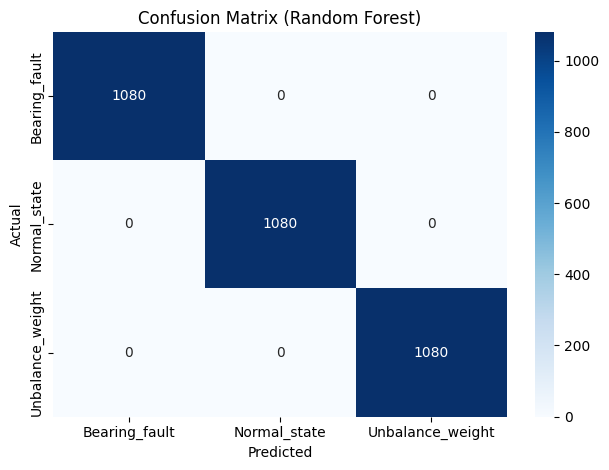


Cross-validated accuracy scores for Random Forest: [1.         0.95895062 1.         0.98950617 1.        ]
Mean cross-validated accuracy for Random Forest: 0.9897
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best hyperparameters found by GridSearchCV for XGBoost:
{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'subsample': 0.8}
XGBoost Accuracy: 1.0000

Classification Report for XGBoost:
                  precision    recall  f1-score   support

   Bearing_fault       1.00      1.00      1.00      1080
    Normal_state       1.00      1.00      1.00      1080
Unbalance_weight       1.00      1.00      1.00      1080

        accuracy                           1.00      3240
       macro avg       1.00      1.00      1.00      3240
    weighted avg       1.00      1.00      1.00      3240



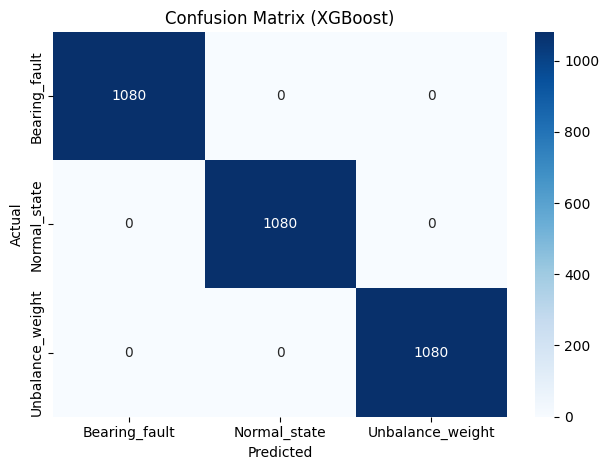


Cross-validated accuracy scores for XGBoost: [0.99969136 0.96666667 1.         0.99104938 1.        ]
Mean cross-validated accuracy for XGBoost: 0.9915


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier  # For boosting model

# Parameters
csv_path = 'final_dataset/CSVs/5s.csv'  # Replace with other CSVs in a loop if needed
numerical_cols = ['mean_flow', 'std_flow', 'edge_ratio', 'keypoint_count', 'fft_peak']
categorical_col = 'view'
# Load dataset
df = pd.read_csv(csv_path)

# Encode target labels
labels = df['class'].astype(str).values
label_names = sorted(set(labels))
label_to_index = {name: i for i, name in enumerate(label_names)}
y = np.array([label_to_index[label] for label in labels])

# Encode categorical 'view' column (0 for 'front', 1 for 'angle')
view_mapping = {'front': 0, 'angle': 1}
df['view_encoded'] = df[categorical_col].map(view_mapping)

# Combine features
X = df[numerical_cols + ['view_encoded']].values.astype(np.float32)

# Normalize numerical features
scaler = StandardScaler()
X[:, :-1] = scaler.fit_transform(X[:, :-1])  # Only normalize numerical part

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train Random Forest with modifications
clf = RandomForestClassifier(
    n_estimators=50,  # Reduced number of estimators
    max_depth=5,  # Limit the depth of the trees to avoid overfitting
    min_samples_split=5,  # Increase min samples for splitting a node
    min_samples_leaf=3,  # Increase min samples for a leaf
    random_state=42,
    class_weight='balanced',  # Handle class imbalance
    max_features='sqrt'  # Use square root of features for splitting
)

# Hyperparameter tuning using GridSearchCV for RandomForest
param_grid = {
    'n_estimators': [100, 150],  # Increase the number of estimators
    'max_depth': [5, 10, 15],  # Limit depth to avoid overfitting
    'min_samples_split': [5, 10],  # Increase min samples for splitting
    'min_samples_leaf': [3, 4],  # Increase min samples for leaf
    'max_features': ['sqrt', 'log2'],
    'min_impurity_decrease': [0.0, 0.01]  # Add impurity decrease to regularize
}

# Grid search with cross-validation for RandomForest
grid_search_rf = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)

# Print best parameters from grid search for RandomForest
print("Best hyperparameters found by GridSearchCV for RandomForest:")
print(grid_search_rf.best_params_)

# Evaluate the best RandomForest model
best_rf_clf = grid_search_rf.best_estimator_

# Test the model
y_pred_rf = best_rf_clf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}\n")

# Detailed report for RandomForest
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=label_names))

# Confusion matrix for RandomForest
conf_mat_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_mat_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Random Forest)")
plt.tight_layout()
plt.show()

# Cross-validation for better evaluation of RandomForest
cv_scores_rf = cross_val_score(best_rf_clf, X, y, cv=5, scoring='accuracy')
print(f"\nCross-validated accuracy scores for Random Forest: {cv_scores_rf}")
print(f"Mean cross-validated accuracy for Random Forest: {cv_scores_rf.mean():.4f}")

# Now, let's try XGBoost for boosting
xgb_clf = XGBClassifier(
    n_estimators=100,  # Number of trees
    max_depth=5,  # Limit tree depth
    learning_rate=0.05,  # Lower learning rate
    subsample=0.8,  # Fraction of data to be used for each tree
    colsample_bytree=0.8,  # Fraction of features for each tree
    random_state=42
)

# Hyperparameter tuning using GridSearchCV for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 150],
    'max_depth': [5, 10],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

# Grid search with cross-validation for XGBoost
grid_search_xgb = GridSearchCV(estimator=xgb_clf, param_grid=param_grid_xgb, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search_xgb.fit(X_train, y_train)

# Print best parameters from grid search for XGBoost
print("Best hyperparameters found by GridSearchCV for XGBoost:")
print(grid_search_xgb.best_params_)

# Evaluate the best XGBoost model
best_xgb_clf = grid_search_xgb.best_estimator_

# Test the model
y_pred_xgb = best_xgb_clf.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb:.4f}\n")

# Detailed report for XGBoost
print("Classification Report for XGBoost:")
print(classification_report(y_test, y_pred_xgb, target_names=label_names))

# Confusion matrix for XGBoost
conf_mat_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(conf_mat_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (XGBoost)")
plt.tight_layout()
plt.show()

# Cross-validation for better evaluation of XGBoost
cv_scores_xgb = cross_val_score(best_xgb_clf, X, y, cv=5, scoring='accuracy')
print(f"\nCross-validated accuracy scores for XGBoost: {cv_scores_xgb}")
print(f"Mean cross-validated accuracy for XGBoost: {cv_scores_xgb.mean():.4f}")
